## Capstone Project - The Battle of Neighborhoods
**1.Introductions & Business Problem:**

Having a successful restaurant is a difficult task that requires significant amount of time and ensuring your menu is original and distinct compared to others. Having a successful restaurant in New York City is the pinnacle for some chefs career. So, it is evident that to survive in such competitive market it is very important to strategically plan. Factors need to be studied in order to decide on the Location such as:

1. New York Population
2. New York City Demographics
3. Are there any Farmers Markets, Wholesale markets etc nearby so that the ingredients can be purchased fresh to maintain quality and cost?
4. Are there any venues like Gyms, Entertainment zones, Parks etc nearby where floating population is high etc
5. Who are the competitors in that location?
6. Cuisine served / Menu of the competitors
7. Segmentation of the Borough Even though well-funded XYZ Company Ltd. need to choose the correct location to start its first venture. If this is successful, they can replicate the same in other locations. This would interest anyone who wants to start a new restaurant in New York city.

**2. Data:**

One city will be analysed in this project: New York City. We will be using the below datasets for analysing New York city

Data 1: Neighbourhood has a total of 5 boroughs and 306 neighbourhoods. In order to segment the neighbourhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighbourhoods that exist in each borough as well as the latitude and longitude coordinates of each neighbourhood. Data source: https://cocl.us/new_york_dataset 

**Description: This data set contains the required information. And we will use this data set to explore various neighbourhoods of New York city.**

Date 2: Indian restaurants in each neighbourhood of New York city. Data source: Foursquare API Description: By using this api we will get all the venues in each neighbourhood. We can filter these venues to get only Indian restaurants. Data 3: GeoSpace data Data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm Description: By using this geo space data we will get the New York Borough boundaries that will help us visualize choropleth map.

Analysis

We will import the required libraries for python.

pandas and numpy for handling data.
request module for using FourSquare API.
geopy to get co-ordinates of City of New York.
folium to visualize the results on a map

In [8]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup

!pip install geocoder

import os
!conda install -c conda-forge folium
import folium # map rendering library
!conda install -c conda-forge geocoder
!conda install -c conda-forge geopy --yes
import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

    100% |████████████████████████████████| 102kB 3.4MB/s a 0:00:011
    100% |████████████████████████████████| 829kB 694kB/s ta 0:00:011
  Running setup.py bdist_wheel for future ... done
  Stored in directory: /Users/arielromero/Library/Caches/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
You are using pip version 9.0.1, however version 20.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Solving environment: \ WARNING conda.resolve:_get_sat_solver_cls(57): Could not run SAT solver through interface 'pycosat'.
failed with initial frozen solve. Retrying with flexible solve.

CondaDependencyError: Cannot run solver. No functioning SAT implementations available.

Solving environment: / WARNING conda.resolve:_get_sat_solver_cls(57): Could not run SAT solver through interface 'pycosat'.
failed with initial frozen solve. Retrying with flexible solve.

CondaDependencyError: Cannot run solver. No f

Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [9]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to interact with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.



In [10]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = '0G0KFCU55P01WMUAE5ZSE1NRPQQIP5F0J5EY1ZI0IKHQDNYG' # your Foursquare ID
    CLIENT_SECRET = 'QU5PJIGT233ERHLCAVAPFPLYPGJ1KDN1YJYTFJHRBADVWJWM' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [11]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '0G0KFCU55P01WMUAE5ZSE1NRPQQIP5F0J5EY1ZI0IKHQDNYG' # your Foursquare ID
    CLIENT_SECRET = 'QU5PJIGT233ERHLCAVAPFPLYPGJ1KDN1YJYTFJHRBADVWJWM'# your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [12]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [15]:
# get new york data
new_york_data=get_new_york_data()

In [16]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [17]:
new_york_data.shape

(306, 4)

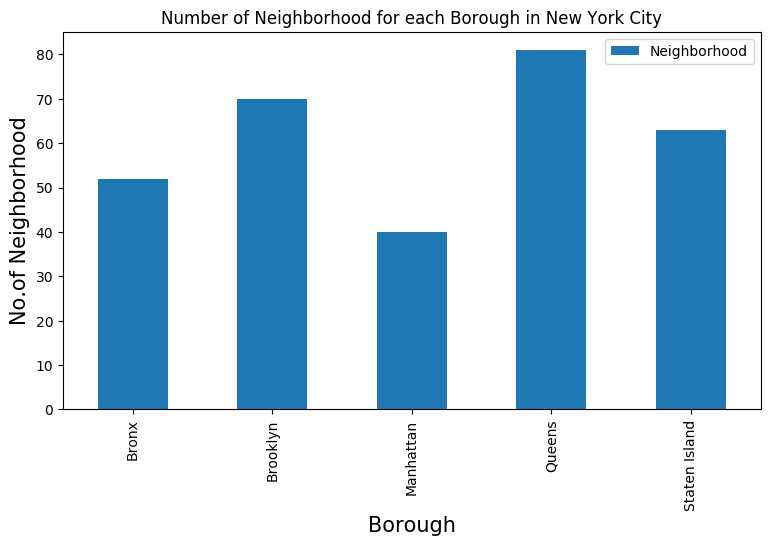

In [18]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Now we will collect Spanish restaurants for each Neighborhood

In [24]:
# prepare neighborhood list that contains Italian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_restaurants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Italian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(italian_restaurants)))
    for restaurant_detail in italian_restaurants.values.tolist():
        id, name , category=restaurant_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Italian Restaurants in Wakefield, Bronx:0
( 2 / 306 ) Italian Restaurants in Co-op City, Bronx:0
( 3 / 306 ) Italian Restaurants in Eastchester, Bronx:0
( 4 / 306 ) Italian Restaurants in Fieldston, Bronx:0
( 5 / 306 ) Italian Restaurants in Riverdale, Bronx:1
( 6 / 306 ) Italian Restaurants in Kingsbridge, Bronx:1
( 7 / 306 ) Italian Restaurants in Marble Hill, Manhattan:0
( 8 / 306 ) Italian Restaurants in Woodlawn, Bronx:1
( 9 / 306 ) Italian Restaurants in Norwood, Bronx:0
( 10 / 306 ) Italian Restaurants in Williamsbridge, Bronx:0
( 11 / 306 ) Italian Restaurants in Baychester, Bronx:2
( 12 / 306 ) Italian Restaurants in Pelham Parkway, Bronx:3
( 13 / 306 ) Italian Restaurants in City Island, Bronx:3
( 14 / 306 ) Italian Restaurants in Bedford Park, Bronx:1
( 15 / 306 ) Italian Restaurants in University Heights, Bronx:0
( 16 / 306 ) Italian Restaurants in Morris Heights, Bronx:0
( 17 / 306 ) Italian Restaurants in Fordham, Bronx:10
( 18 / 306 ) Italian Restaurants in E

( 138 / 306 ) Italian Restaurants in Richmond Hill, Queens:1
( 139 / 306 ) Italian Restaurants in Flushing, Queens:0
( 140 / 306 ) Italian Restaurants in Long Island City, Queens:3
( 141 / 306 ) Italian Restaurants in Sunnyside, Queens:1
( 142 / 306 ) Italian Restaurants in East Elmhurst, Queens:1
( 143 / 306 ) Italian Restaurants in Maspeth, Queens:2
( 144 / 306 ) Italian Restaurants in Ridgewood, Queens:3
( 145 / 306 ) Italian Restaurants in Glendale, Queens:1
( 146 / 306 ) Italian Restaurants in Rego Park, Queens:1
( 147 / 306 ) Italian Restaurants in Woodhaven, Queens:0
( 148 / 306 ) Italian Restaurants in Ozone Park, Queens:1
( 149 / 306 ) Italian Restaurants in South Ozone Park, Queens:1
( 150 / 306 ) Italian Restaurants in College Point, Queens:0
( 151 / 306 ) Italian Restaurants in Whitestone, Queens:5
( 152 / 306 ) Italian Restaurants in Bayside, Queens:3
( 153 / 306 ) Italian Restaurants in Auburndale, Queens:2
( 154 / 306 ) Italian Restaurants in Little Neck, Queens:6
( 155 

( 271 / 306 ) Italian Restaurants in Mount Hope, Bronx:0
( 272 / 306 ) Italian Restaurants in Sutton Place, Manhattan:5
( 273 / 306 ) Italian Restaurants in Hunters Point, Queens:7
( 274 / 306 ) Italian Restaurants in Turtle Bay, Manhattan:1
( 275 / 306 ) Italian Restaurants in Tudor City, Manhattan:0
( 276 / 306 ) Italian Restaurants in Stuyvesant Town, Manhattan:3
( 277 / 306 ) Italian Restaurants in Flatiron, Manhattan:4
( 278 / 306 ) Italian Restaurants in Sunnyside Gardens, Queens:3
( 279 / 306 ) Italian Restaurants in Blissville, Queens:0
( 280 / 306 ) Italian Restaurants in Fulton Ferry, Brooklyn:2
( 281 / 306 ) Italian Restaurants in Vinegar Hill, Brooklyn:2
( 282 / 306 ) Italian Restaurants in Weeksville, Brooklyn:0
( 283 / 306 ) Italian Restaurants in Broadway Junction, Brooklyn:0
( 284 / 306 ) Italian Restaurants in Dumbo, Brooklyn:2
( 285 / 306 ) Italian Restaurants in Manor Heights, Staten Island:0
( 286 / 306 ) Italian Restaurants in Willowbrook, Staten Island:1
( 287 / 3

In [25]:
italian_rest_ny.shape

(529, 4)

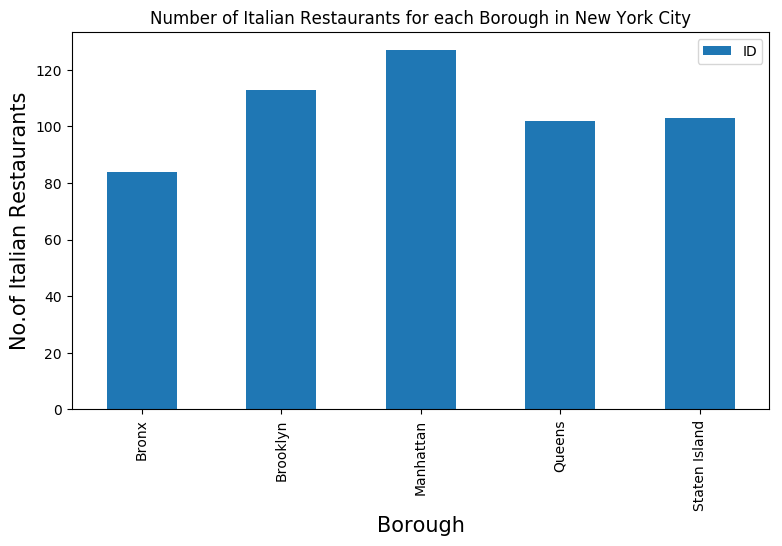

In [26]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Italian Restaurants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Restaurants', fontsize=15)
#giving a bar plot
italian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Italian Restaurants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Restaurants', fontsize=15)
#giving a bar plot
italian_rest_ny.groupby('Neighborhood')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [32]:
italian_rest_ny[italian_rest_ny['Neighborhood']=='Forest Hills']

,Borough,Neighborhood,ID,Name
284,Queens,Forest Hills,4c8d2ce6f87e224bfb6d3b05,Tuscan Hills
285,Queens,Forest Hills,4ba0203af964a520105c37e3,Portofino Ristorante


Now we will get the ranking of each resturant for further analysis.

In [34]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in italian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_ny),')','processed')
    italian_rest_stats_ny = italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                  Name  Likes  Rating  Tips
0  55aaee4d498e3cbb70e625d6  Bella Notte Pizzeria      9     6.8     4
( 1 / 529 ) processed
                         ID                  Name  Likes  Rating  Tips
0  55aaee4d498e3cbb70e625d6  Bella Notte Pizzeria      9     6.8     4
( 2 / 529 ) processed
                         ID                    Name  Likes  Rating  Tips
0  511edb6de4b0d58346fd272d  Patrizia's Of Woodlawn     18     8.5    14
( 3 / 529 ) processed
                         ID        Name  Likes  Rating  Tips
0  4c9518076b35a143d5dc21dc  Fratelli's     22     8.7     6
( 4 / 529 ) processed
                         ID          Name  Likes  Rating  Tips
0  5411894d498e4a254a11a46c  Olive Garden     26     7.4     8
( 5 / 529 ) processed
                         ID    Name  Likes  Rating  Tips
0  4bf96ae65317a593d837017f  Enzo's     26     8.6    11
( 6 / 529 ) processed
                         ID        Name  Likes  Rating  Tips
0  4b10591af964

KeyError: 'venue'

In [35]:
italian_rest_stats_ny.shape

(51, 7)

In [36]:
italian_rest_ny.shape

(529, 4)

So we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required

In [38]:
italian_rest_stats_ny.to_csv('italian_rest_stats_ny.csv', index=False)

Lets verify the data from saved csv file

In [39]:
italian_rest_stats_ny_csv=pd.read_csv('italian_rest_stats_ny.csv')

In [40]:
italian_rest_stats_ny_csv.shape

(51, 7)

In [41]:
italian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,9,6.8,4
1,Bronx,Kingsbridge,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,9,6.8,4
2,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn,18,8.5,14
3,Bronx,Baychester,4c9518076b35a143d5dc21dc,Fratelli's,22,8.7,6
4,Bronx,Baychester,5411894d498e4a254a11a46c,Olive Garden,26,7.4,8


In [42]:
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 7 columns):
Borough         51 non-null object
Neighborhood    51 non-null object
ID              51 non-null object
Name            51 non-null object
Likes           51 non-null object
Rating          51 non-null float64
Tips            51 non-null object
dtypes: float64(1), object(6)
memory usage: 2.9+ KB


We see that values like Likes, Tips are string values. We would need to convert them into float for further analysis

In [44]:
italian_rest_stats_ny['Likes']=italian_rest_stats_ny['Likes'].astype('float64')

In [45]:
italian_rest_stats_ny['Tips']=italian_rest_stats_ny['Tips'].astype('float64')

In [46]:
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 7 columns):
Borough         51 non-null object
Neighborhood    51 non-null object
ID              51 non-null object
Name            51 non-null object
Likes           51 non-null float64
Rating          51 non-null float64
Tips            51 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.9+ KB


In [47]:
# Resturant with maximum Likes
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Likes'].idxmax()]

Borough                            Bronx
Neighborhood                    Van Nest
ID              3fd66200f964a5207bf11ee3
Name                   F & J Pine Tavern
Likes                                177
Rating                               8.7
Tips                                  72
Name: 37, dtype: object

In [48]:
# Resturant with maximum Rating
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Rating'].idxmax()]

Borough                            Bronx
Neighborhood                     Fordham
ID              4acf80aef964a52025d420e3
Name                 Tino's Delicatessen
Likes                                147
Rating                               9.3
Tips                                  48
Name: 12, dtype: object

In [49]:
# Resturant with maximum Tips
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Tips'].idxmax()]

Borough                            Bronx
Neighborhood                    Van Nest
ID              3fd66200f964a5207bf11ee3
Name                   F & J Pine Tavern
Likes                                177
Rating                               8.7
Tips                                  72
Name: 37, dtype: object

Now lets visualize neighborhood with maximum average rating of resturants



In [50]:
ny_neighborhood_stats=italian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [51]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
2,Belmont,8.685714
16,Woodlawn,8.500000
9,Morrisania,8.200000
5,Fordham,8.050000
0,Baychester,8.050000
14,Van Nest,8.000000
7,Melrose,7.800000
11,Pelham Parkway,7.766667
1,Bedford Park,7.700000
8,Morris Park,7.500000


Above are the top neighborhoods with top average rating of Italian restaurants

In [53]:
ny_borough_stats=italian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [54]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()


,Borough,Average Rating
0,Bronx,7.615686


Similarly these are the average rating of Indian Resturants for each Borough

Lets visualize it

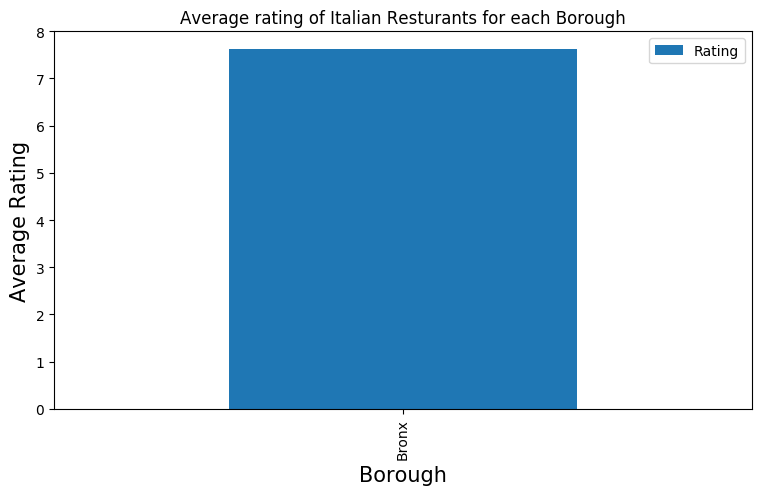

In [56]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Italian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
italian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()


We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map

In [57]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]
ny_neighborhood_stats

,Neighborhood,Average Rating


We will join this dataset to original new york data to get longitude and latitude

In [58]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating


Now we will show this data on a map

In [60]:
 #create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)


# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )


Lets add a new field to dataframe for labeling purpose



In [61]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'


In [63]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

**Results** 1.We see that Manhattan has the most Italian restaurants out of all the Boroughs.

**Conclusion**

The highest rated restaurants are located in Belmont.Bronx has the least amount of restaurants out of all the Boroughs.
